In [ ]:
# Импорт всех необходимых библиотек для работы

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, ZeroPadding2D, Input, Activation
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import activations
import tensorflow as tf
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Загрузка токена аутентификации (если работа идёт не через платформу Kaggle)
file = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Просматриваем содержимое текущей директории
!ls

kaggle.json  model.h5  sample_data


In [ ]:
# Копирование токена в каталог .kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle

In [ ]:
# Установка прав доступа к файлу
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
# Загружаем данные с сайта Kaggle
!kaggle competitions download -c digit-recognizer

 33% 5.00M/15.3M [00:00<00:00, 50.6MB/s]
100% 15.3M/15.3M [00:00<00:00, 116MB/s] 


In [ ]:
!ls

digit-recognizer.zip  model.h5	sample_data


In [ ]:
# Распаковываем данные из архива
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
!ls

digit-recognizer.zip  model.h5	sample_data  sample_submission.csv  test.csv  train.csv


In [ ]:
# Данные для обучения
!head train.csv

label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel1

In [ ]:
# Данные для тестирования
!head test.csv

pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pix

In [ ]:
# Пример файла с решением
!head sample_submission.csv

ImageId,Label
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


(28000, 784)


In [ ]:
# Загрузка данных для обучения сети

# Тренировочный датасет стандартного MNIST
train_mnist = np.loadtxt('mnist_train.csv', skiprows=1, delimiter=',')

# Тестовый датасет стандартного MNIST
test_mnist = np.loadtxt('mnist_test.csv', skiprows=1, delimiter=',')

# Тренировочный датасет MNIST с соревнования Kaggle
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')

# Объединяем обучающие наборы с kaggle и mnist, а также тестовый набор из mnist (для увеличения выборки)
dataset = np.concatenate((train_dataset, train_mnist, test_mnist))

print(dataset.shape)

ValueError: ignored

(28000, 784)

In [ ]:
dataset.shape

(112000, 785)

In [ ]:
# Тренировочный датасет MNIST с соревнования Kaggle
train_dataset = np.loadtxt('train.csv', skiprows=1, delimiter=',')
train_dataset.shape

(42000, 785)

In [ ]:
train_mnist.shape

(60000, 785)

In [ ]:
train_dataset.shape

(42000, 785)

In [ ]:
# Объединяем обучающие наборы с kaggle и mnist, а также тестовый набор из mnist (для увеличения выборки)
dataset = np.concatenate((train_dataset, train_mnist, test_mnist))

In [ ]:
dataset

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [4., 0., 0., ..., 0., 0., 0.],
       [5., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.]])

In [ ]:
dataset[200:201, 400:401]

array([[81.]])

In [ ]:
# Выделяем данные для обучения (без первого столбца с ответами)
x_train = dataset[:, 1:]

# Изменяем размер данных обучающей выборки
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)

# Размер входа
input_shape = (28, 28, 1)

In [ ]:
# Нормализация данных для обучения
x_train /= 255.0

In [ ]:
x_train[1].shape

(28, 28, 1)

In [ ]:
# Выделяем правильные ответы
y_train = dataset[:, 0]

In [ ]:
y_train[:5]

array([1., 0., 1., 4., 0.])

In [ ]:
# Преобразуем ответы в формат one hot encoding
y_train = utils.to_categorical(y_train)

In [ ]:
y_train[:5]

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
random_seed = 2

# Разделяем данные на два набора - для обучающей выборки и для тестирования
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [ ]:
X_train.shape

(100800, 28, 28, 1)

In [ ]:
# Создаём генератор для расширения данных
# Это необходимо, т.к. 37800 данных для обучения будет недостаточно
# чтобы хорошо обучить нейронную сеть

datagen = ImageDataGenerator(
   rotation_range=10,          # Поворот на случайный угол до 10 градусов
   zoom_range=0.1,            # Увеличение размера до 10 %
   width_shift_range=0.1,      # Сдвих влево / вправо до 10 процентов
   height_shift_range=0.1,     # Сдвиг вверх / вниз до 10 процентов
)

#datagen = ImageDataGenerator(
        #featurewise_center=False,             # Не устанавливать входное среднее значение равным 0 для всего набора данных
        #samplewise_center=False,              # Не устанавливать среднее значение каждой выборки в 0
        #featurewise_std_normalization=False,  # Не разделять входные данные по стандартному значению набора данных
        #samplewise_std_normalization=False,   # divide each input by its std
        #zca_whitening=False,                  # Не использовать ZCA
        #rotation_range=20,                    # Поворот на случайный угол до 10 градусов
        #zoom_range = 0.2,                     # Увеличение размера до 10 %
        #width_shift_range=0.2,                # Сдвих влево / вправо до 10 процентов
        #height_shift_range=0.2,               # Сдвиг вверх / вниз до 10 процентов
        #horizontal_flip=False,                # Переворачивание данных по горизонтали
        #vertical_flip=False                   # Переворачивание данных по вертикали
#)

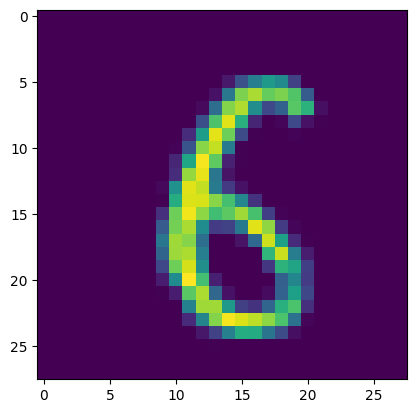

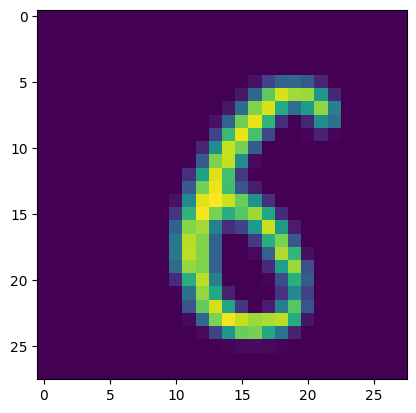

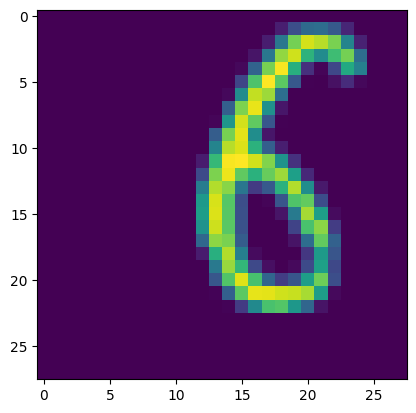

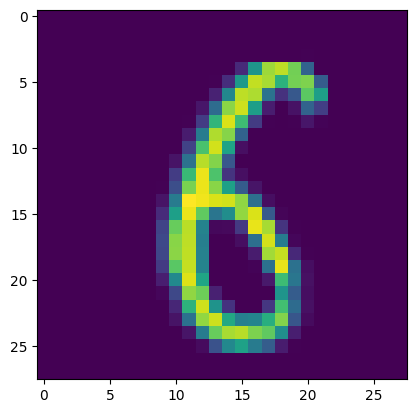

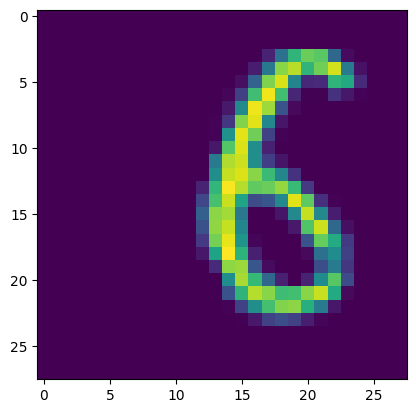

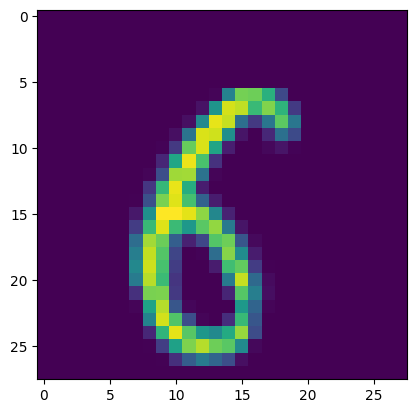

In [ ]:
# Просмотр данных которые потенциально могут быть сгенерированы
i = 0
data = X_train[0]
data = np.expand_dims(data, axis=0)

# Цикл сборки изображений
for batch in datagen.flow(data, batch_size=1):
  plt.figure(i)
  imgplot = plt.imshow(batch[0][:,:,0])

  i += 1
  if i % 6 == 0:
    break

# Вывод изображений
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
img = Image.open('/content/eight.png').convert("L")
new_image = img.resize((28, 28))

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.imshow(new_image)

plt.show()

FileNotFoundError: ignored

In [ ]:
image = tf.keras.preprocessing.image

img = Image.open('/content/eight.png').convert("L")
new_image = img.resize((28, 28), )

img = image.load_img("/content/eight.png", target_size=(28, 28), grayscale=True)
x = np.array(new_image).reshape((28, 28, 1))
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
print(images.shape)
images = images / 255.0

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.imshow(img)
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot()
ax.imshow(new_image)

plt.show()

In [ ]:
# Создание свёрточной нейронной сети

model = Sequential()

# Входной слой
model.add(Input(shape=(28, 28, 1)))
# Добавление строк и столбцов с нулями сверху, снизу, слева и справа от изображения
model.add(ZeroPadding2D(padding=(1, 1), input_shape=(28, 28, 1)))
# Слой свёрточной сети с ядром свёртки размера 5x5 и фильтром 32
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
# Batch-нормализация (ускоряем обучение, стабилизируем нейронную сеть)
model.add(BatchNormalization())
# Слой свёртки с ядром свёртки 5x5 и фильтром 32
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
# Batch-нормализация
model.add(BatchNormalization())
# Слой функции активации "relu"
model.add(Activation(activations.relu))
# Максимальная операция объединения в пул для 2D-пространственных данных
model.add(MaxPooling2D(pool_size=(2,2)))
# Добавление нулевых строк и столбцов
model.add(ZeroPadding2D(padding=(1, 1)))
# Применение метода регуляризации, который случайным образом удаляет входные единицы во время обучения (20%)
model.add(Dropout(0.2))

# Свёрточный слой с ядром 3x3 и фильтром 64
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
# Batch-нормализация
model.add(BatchNormalization())
# Свёрточнй слой с ядром 3x3 и фильтром 64
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
# Batch-нормализация
model.add(BatchNormalization())
# Функция активации "relu"
model.add(Activation(activations.relu))
# Операция объединения в пул для 2D-пространственных данных (максимум)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# Случайное удаление единиц с вероятностью 20%
model.add(Dropout(0.2))

# Свёрточный слой с ядром 3x3 и фильтром 256
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
# Batch-нормализация
model.add(BatchNormalization())
# Свёрточный слой с фильтром 256 и яддром 3x3
model.add(Conv2D(filters = 256, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
# Batch-нормализация
model.add(BatchNormalization())
# Функция активации "relu"
model.add(Activation(activations.relu))
# Операция объединения в пул для 2D-пространственных данных (максимум)
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# Случайное удаление единиц с вероятностью 30%
model.add(Dropout(0.3))

# Сглаживание многомерных тензоров в одно измерение (конвертация в вектор размера 1xN)
model.add(Flatten())
# Полносвязный слой с функцией активации "relu"
model.add(Dense(128, activation = "relu"))
# Случайное удаление единиц с вероятностью 40%
model.add(Dropout(0.4))
# Полносвязный слой с функцией активации "softmax" (категоризация)
model.add(Dense(10, activation = "softmax"))

In [ ]:
# Компиляция нейронной сети
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 30, 30, 1)         0         
 g2D)                                                            
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        832       
                                                                 
 batch_normalization (Batch  (None, 30, 30, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        25632     
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                        

In [ ]:
# Обучение нейронной сети

# Колбэк для сохранения лучшего варианта работы нейронной сети
checkpoint = ModelCheckpoint('mnist-cnn.hd5',
                             monitor='val_accuracy',     # Доля правильных ответов на проверочном множестве
                             save_best_only=True,        # Сохраняем только лучший результат
                             verbose=1)                  # Вывод логов

In [ ]:
# Колбэк для изменения скорости обучения
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', # Метрика
                                            patience=3,             # Число эпох без улучшения результата
                                            verbose=1,              # Вывод логов
                                            factor=0.5,             # Коэффициент на который мы будем умножать скорость обучения сети
                                            min_lr=0.00001)         # Минимальная скорость обучения сети

In [ ]:
# Размер мини-выборки
batch_size = 32

In [ ]:
# Сборка модели с сохранением истории изменений
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=35,
                    validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size,
                    verbose=1,
                    callbacks=[checkpoint, learning_rate_reduction],
                    shuffle=True)

Epoch 1/35
3150/3150 [==============================] - ETA: 0s - loss: 0.4560 - accuracy: 0.8530
Epoch 1: val_accuracy improved from -inf to 0.97991, saving model to mnist-cnn.hd5
3150/3150 [==============================] - 66s 20ms/step - loss: 0.4560 - accuracy: 0.8530 - val_loss: 0.0908 - val_accuracy: 0.9799 - lr: 0.0010
Epoch 2/35
3148/3150 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9676
Epoch 2: val_accuracy improved from 0.97991 to 0.98732, saving model to mnist-cnn.hd5
3150/3150 [==============================] - 59s 19ms/step - loss: 0.1242 - accuracy: 0.9676 - val_loss: 0.0480 - val_accuracy: 0.9873 - lr: 0.0010
Epoch 3/35
3150/3150 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9760
Epoch 3: val_accuracy improved from 0.98732 to 0.98839, saving model to mnist-cnn.hd5
3150/3150 [==============================] - 60s 19ms/step - loss: 0.0966 - accuracy: 0.9760 - val_loss: 0.0402 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4

In [ ]:
model.evaluate(X_val, Y_val)

350/350 [==============================] - 1s 4ms/step - loss: 0.0062 - accuracy: 0.9983


[0.006166147533804178, 0.9983035922050476]

In [ ]:
# Загрузка весов обученной сети (я дообучил свою сеть на более чем 150-ти эпохах чтобы достичь результата в 0.9969)
model.load_weights('model.hd5')

In [ ]:
model.evaluate(X_val, Y_val)

350/350 [==============================] - 10s 4ms/step - loss: 0.0083 - accuracy: 0.9986


[0.008267395198345184, 0.9985714554786682]

In [ ]:
new_model = tf.keras.models.load_model('/content/mnist-cnn.hd5')

In [ ]:
image = tf.keras.preprocessing.image

img = Image.open('/content/eight.png').convert("L")
new_image = img.resize((28, 28))

x = np.array(new_image).reshape((28, 28, 1))
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

classes = new_model.predict(images, batch_size=1)
result = int(np.argmax(classes))

print(result)

1/1 [==============================] - 0s 34ms/step
8


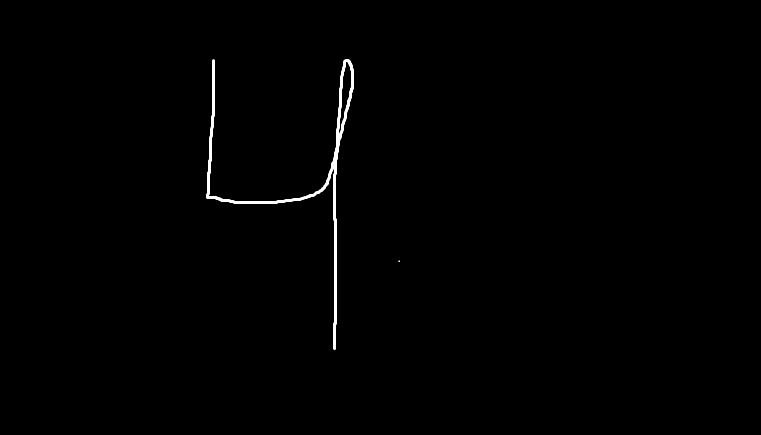

In [ ]:
model.evaluate(X_val, Y_val)

350/350 [==============================] - 1s 4ms/step - loss: 0.0067 - accuracy: 0.9985


[0.006668255664408207, 0.9984821677207947]

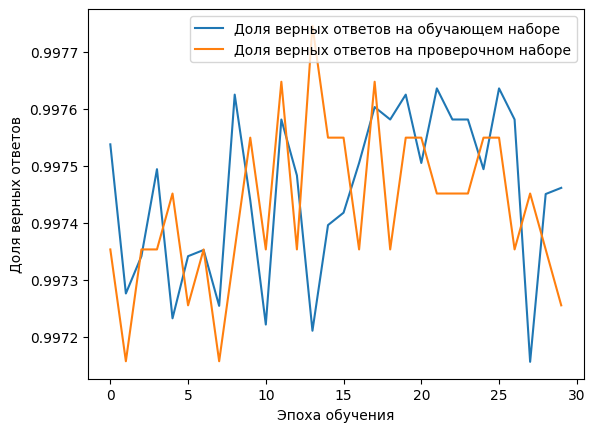

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

In [ ]:
# Загружаем данные для распознавания
test_dataset = np.loadtxt('test.csv', skiprows=1, delimiter=",")

In [ ]:
test_dataset[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
x_test = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

In [ ]:
# Нормализация данных
x_test = x_test / 255.0

In [ ]:
# Распознование рукописных цифр из тестового набора данных
predictions = model.predict(x_test)

875/875 [==============================] - 3s 3ms/step


In [ ]:
predictions[:5]

array([[0.0000000e+00, 8.1939038e-36, 1.0000000e+00, 4.3472412e-34,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.1332387e-29,
        1.1480576e-33, 0.0000000e+00],
       [1.0000000e+00, 2.4062153e-31, 1.0174474e-28, 3.1862658e-34,
        7.3195696e-29, 8.2826413e-31, 1.8244595e-23, 2.7928532e-33,
        3.0136447e-21, 1.1359192e-21],
       [6.1368495e-16, 3.6827823e-16, 6.4834827e-17, 1.9054537e-11,
        3.4375141e-08, 2.0525657e-13, 1.7666843e-20, 8.0295472e-11,
        4.0608514e-10, 1.0000000e+00],
       [9.9971086e-01, 1.7434823e-07, 7.0493393e-06, 6.7318109e-07,
        1.6293360e-07, 1.4601793e-05, 6.2244893e-05, 1.7780287e-07,
        1.3868230e-04, 6.5306966e-05],
       [0.0000000e+00, 0.0000000e+00, 1.6696656e-29, 1.0000000e+00,
        0.0000000e+00, 4.0483041e-19, 0.0000000e+00, 3.1858556e-32,
        2.9274805e-23, 3.8761950e-31]], dtype=float32)

In [ ]:
# Преобразуем результаты распознавания из формата one hot encoding в цифры
predictions = np.argmax(predictions, axis = 1)

In [ ]:
predictions[:5]

array([2, 0, 9, 0, 3])

In [ ]:
# Подготовка файла с решением для kaggle
out = np.column_stack((range(1, predictions.shape[0]+1), predictions))

In [ ]:
out[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

In [ ]:
# Загружаем результаты в файл
np.savetxt('submission.csv', out, header="ImageId,Label",
           comments="", fmt="%d,%d")

In [ ]:
!head submission.csv

ImageId,Label
1,2
2,0
3,9
4,0
5,3
6,7
7,0
8,3
9,0


In [ ]:
# Отправляем решение на соревнование
!kaggle competitions submit -c digit-recognizer -m "submission for 1 score number 2" -f submission.csv

100% 208k/208k [00:01<00:00, 117kB/s]  
Successfully submitted to Digit Recognizer